# Hourly PSDS - IROMY

## Load Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from andbro__savefig import __savefig

from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path

import os
import pickle
import matplotlib.pyplot as plt

In [2]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero

    min_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])

    return min_psd

In [3]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [4]:
def __get_minimum_psd(psds, f_tmp):

    for i, psd in enumerate(psds):
        if i == 0:
            lowest_value = psd.sum()
            idx = 0

        value = psd.sum()

        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    return psds[idx]

In [5]:
def __get_array_from_dataframe(df):

    from pandas import to_numeric

    ## convert to list
    psds = []
    for col in array(df.columns):

        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [6]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [17]:
## ---------------------------------------

name = "PROMY"
inname = "2023_PROMY_3600"
subdir = "PROMY/"
threshold = 1e8
f_limits = 0.001, 1.0


## ---------------------------------------

path = data_path+f"LNM2/PSDS/"

## load configurations
config = pickle.load(open(path+subdir+inname+"_config.pkl", 'rb'))

config['inname'] = inname
config['inpath'] = path+subdir
config['f_limits'] = f_limits
config['thres'] = threshold
config['station'] = name

config['outpath_figures'] = data_path+f"LNM2/figures/"

config['period_limits'] = [1/config['f_limits'][1], 1/config['f_limits'][0]]


## Methods

In [9]:
def __filter_psds(psds, thresholds):

    from numpy import mean, array

    psds_filtered = []
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

    ## filter for periods larger than 20 seconds
    if mean(psd[0:63]) < thresholds[0]:
        psds_filtered.append(psd)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds: {thresholds[0]} & {thresholds[1]}")
    return array(psds_filtered)

In [10]:
def __load_data_file(path, file):

    from tqdm.notebook import tqdm
    from numpy import array

    psds_all = []
    psds_hourly = read_pickle(path+file)

    for psd in psds_hourly:
        psds_all.append(psd)

    return array(psds_all)

In [11]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [12]:
def __remove_noisy_psds(arr, threshold_mean=1e-16):

    from numpy import delete, shape, sort, array

    l1 = shape(arr)[0]

    idx_to_remove = []
    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if arr[ii,:].mean() > threshold_mean:
            rejected.append(arr[ii,:])
            idx_to_remove.append(ii)

        ## apply default lowe threshold
        if arr[ii,:].mean() < 1e-26:
            rejected.append(arr[ii,:])
            idx_to_remove.append(ii)

    for jj in sort(array(idx_to_remove))[::-1]:
        arr = delete(arr, jj, axis=0)

    l2 = shape(arr)[0]

    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")

    return arr, rejected

In [14]:
def __makeplot_colorlines(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)



    ##____________________________


    fig, axes = plt.subplots(1, 1, figsize=(15,7), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24
    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)

    for n, psd in enumerate(psds):
        axes.loglog(ff, psd, color=colors[n], alpha=0.7)
        p2 = axes.scatter(ff[0], psd[0], s=0.1, c=int(n/N), cmap=cmap, vmin=0, vmax=N)

    for reject in rejected:
         axes.loglog(ff, reject, color='grey', alpha=0.6, zorder=1)

    axes.loglog(ff, __get_median_psd(psds), 'black', zorder=3, alpha=0.6, label="Median")

    axes.grid(True, which="both", ls="-", alpha=0.5)
    axes.legend(loc='lower left')
    axes.tick_params(labelsize=font-2)

#     axes.set_ylim(1e-23, 1e-16)

    axes.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)


    # axes.set_ylabel(r"PSD$_{absolute}$ ($hPa$/$Hz)$", fontsize=font)
    axes.set_ylabel(r"PSD$_{infrasound}$ ($hPa$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes, aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))

    axes.set_title(f"{config['station']} | {day}")

    plt.show();
    return fig

In [15]:
# def __makeplot_colorlines_overview(config, ff, psds, rejected, day):

#     from tqdm.notebook import tqdm
#     from numpy import isnan, median, mean, std, array, zeros
#     from scipy.stats import median_abs_deviation as mad

# #     psds_median = __get_median_psd(array(psds))
# #     psds_minimal = __get_minimal_psd(array(psds))
# #     psds_minimum = __get_minimum_psd(array(psds), ff)


#     ## convert frequencies to periods
#     pp=[]
#     for mm in range(len(ff)):
#         ppp = zeros(len(ff[mm]))
#         ppp = 1/ff[mm]
#         pp.append(ppp)


#     ##____________________________

#     NN = 3

#     fig, axes = plt.subplots(NN,1, figsize=(10,10), sharey=False, sharex=True)

#     plt.subplots_adjust(hspace=0.1)

#     font = 14

# #     N = max(psds[0].shape[0], psds[1].shape[0], psds[2].shape[0])
# #     colors = plt.cm.rainbow(linspace(0, 1, N))

#     N =24
#     colors = plt.cm.rainbow(linspace(0,1,N))
#     cmap = plt.get_cmap('rainbow', 24)


#     ## add Frequency Axis
# #     g = lambda x: 1/x
# #     ax2 = axes[0].secondary_xaxis("top", functions=(g,g))
# #     ax2.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)
# #     ax2.set_xticklabels(ff[2], fontsize=11)
# #     ax2.tick_params(axis='both', labelsize=font-2)


#     for j in range(NN):
#         for n, psd in enumerate(tqdm(psds[j])):
#             axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
#             p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N)

#         for reject in rejected[j]:
#              axes[j].loglog(ff[j],reject, color='grey', alpha=0.6, zorder=1)

#         axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")


#         axes[j].grid(True, which="both", ls="-", alpha=0.5)
#         axes[j].legend(loc='lower left')
#         axes[j].tick_params(labelsize=font-2)


#     axes[NN-1].set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

#     ## panel labels
#     axes[0].text(.01, .99, 'a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font+2)
#     axes[1].text(.01, .99, 'b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font+2)
#     axes[2].text(.01, .99, 'c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font+2)

#     axes[0].set_ylabel(r"PSD$_{vertical}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)
#     axes[1].set_ylabel(r"PSD$_{north}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)
#     axes[2].set_ylabel(r"PSD$_{east}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)

#     ## set colorbar at bottom
#     cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5,
#                        ticks=arange(1,N,2))


#     plt.show();
#     return fig

## RUN for all files 

2023_PROMY_3600_20230922_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


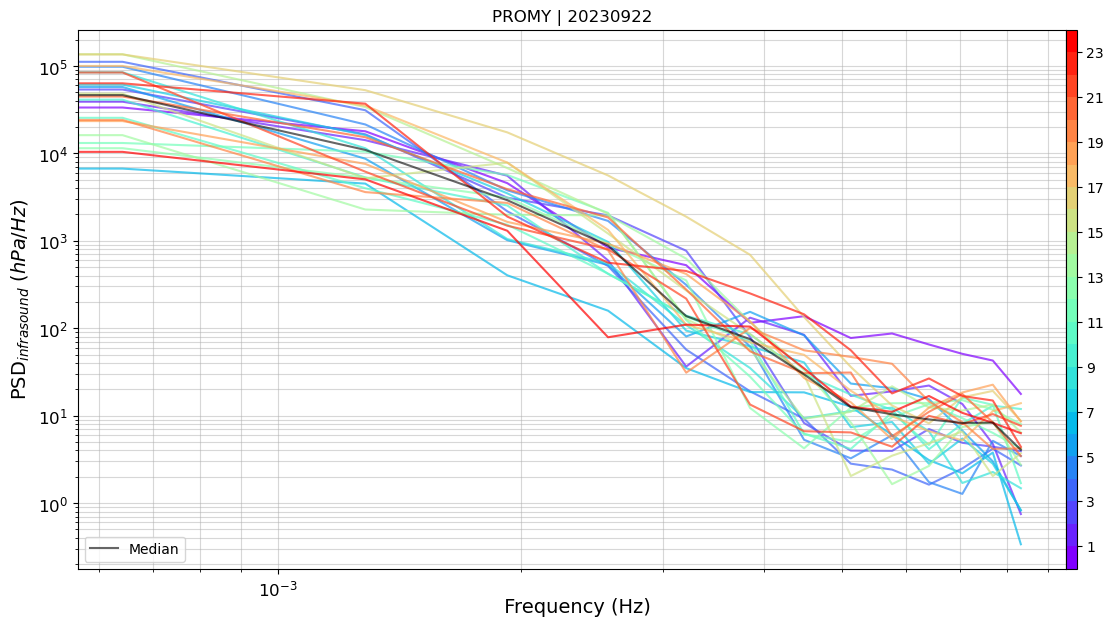


   -> saving /import/kilauea-data/LNM2/figures/PROMY_infrasound_20230922.png ...

   -> Done

2023_PROMY_3600_20230923_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


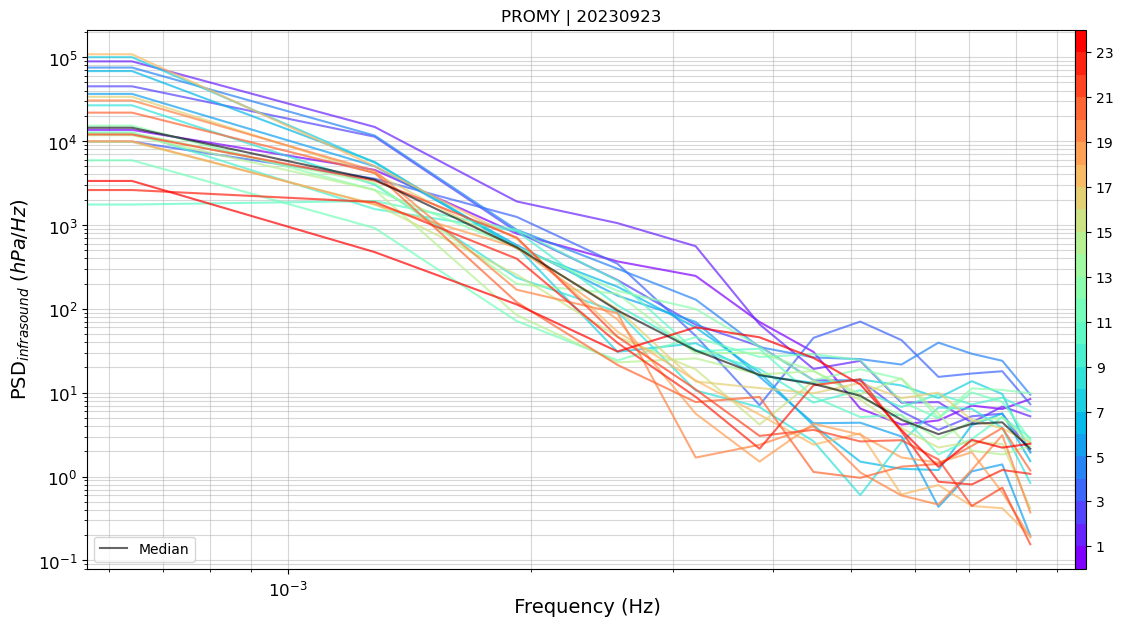


   -> saving /import/kilauea-data/LNM2/figures/PROMY_infrasound_20230923.png ...

   -> Done

2023_PROMY_3600_20230924_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


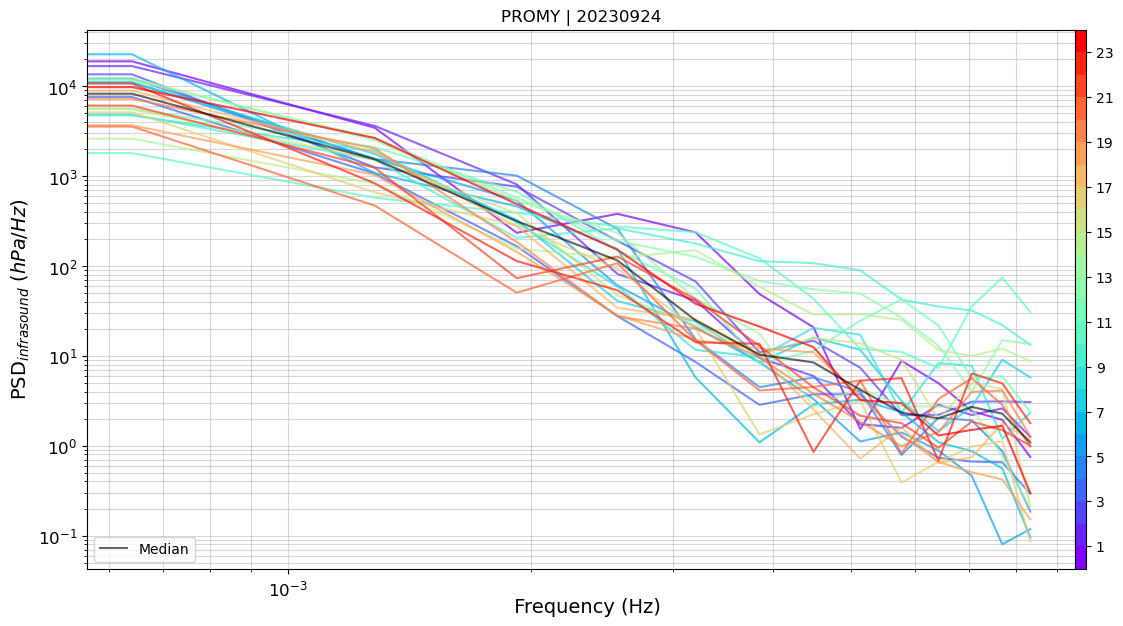


   -> saving /import/kilauea-data/LNM2/figures/PROMY_infrasound_20230924.png ...

   -> Done

2023_PROMY_3600_20230925_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


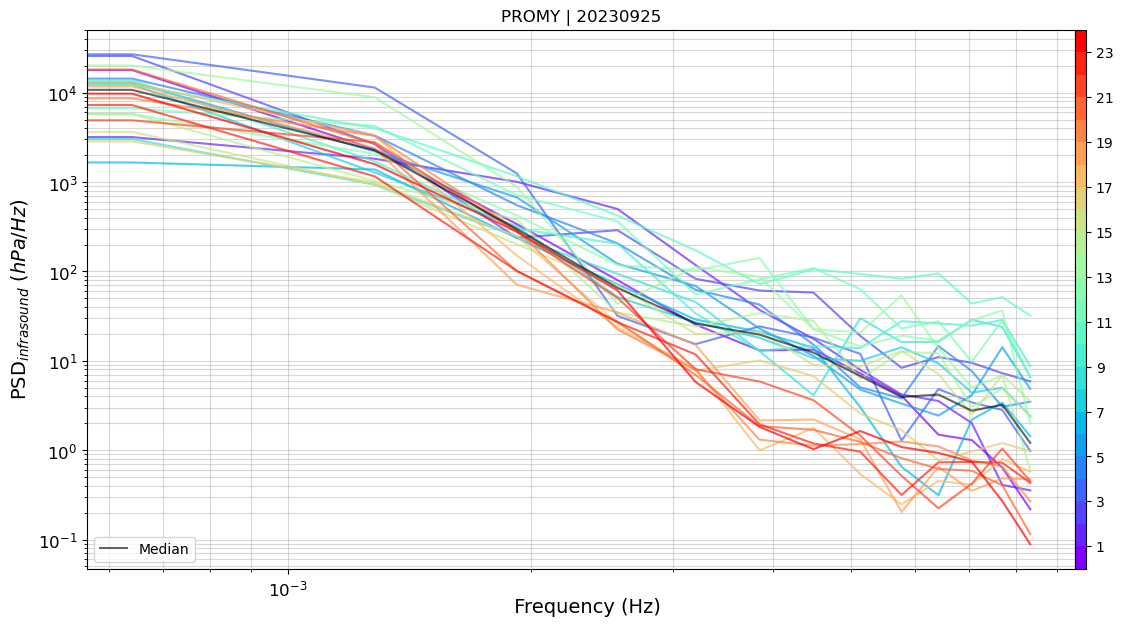


   -> saving /import/kilauea-data/LNM2/figures/PROMY_infrasound_20230925.png ...

   -> Done

2023_PROMY_3600_20230926_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


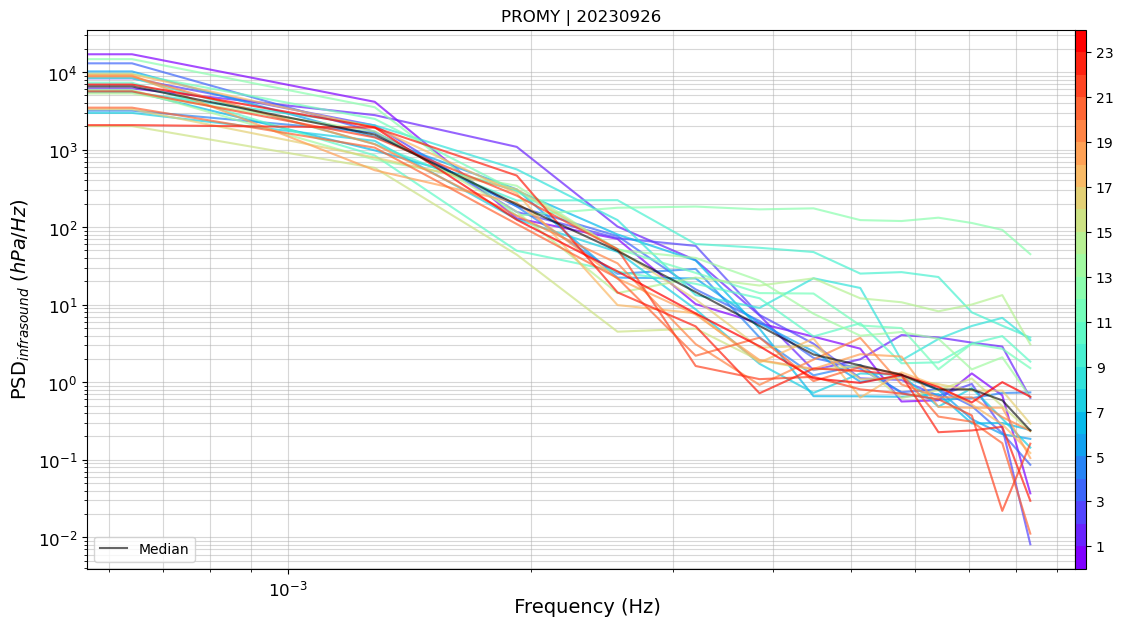


   -> saving /import/kilauea-data/LNM2/figures/PROMY_infrasound_20230926.png ...

   -> Done

2023_PROMY_3600_20230927_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


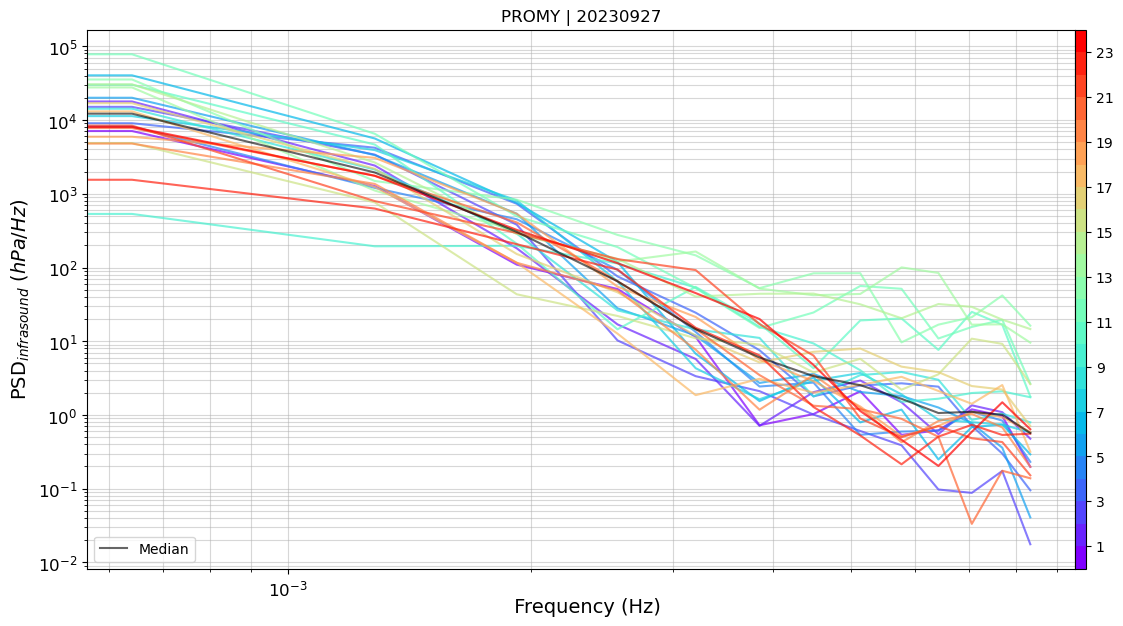


   -> saving /import/kilauea-data/LNM2/figures/PROMY_infrasound_20230927.png ...

   -> Done

2023_PROMY_3600_20230928_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


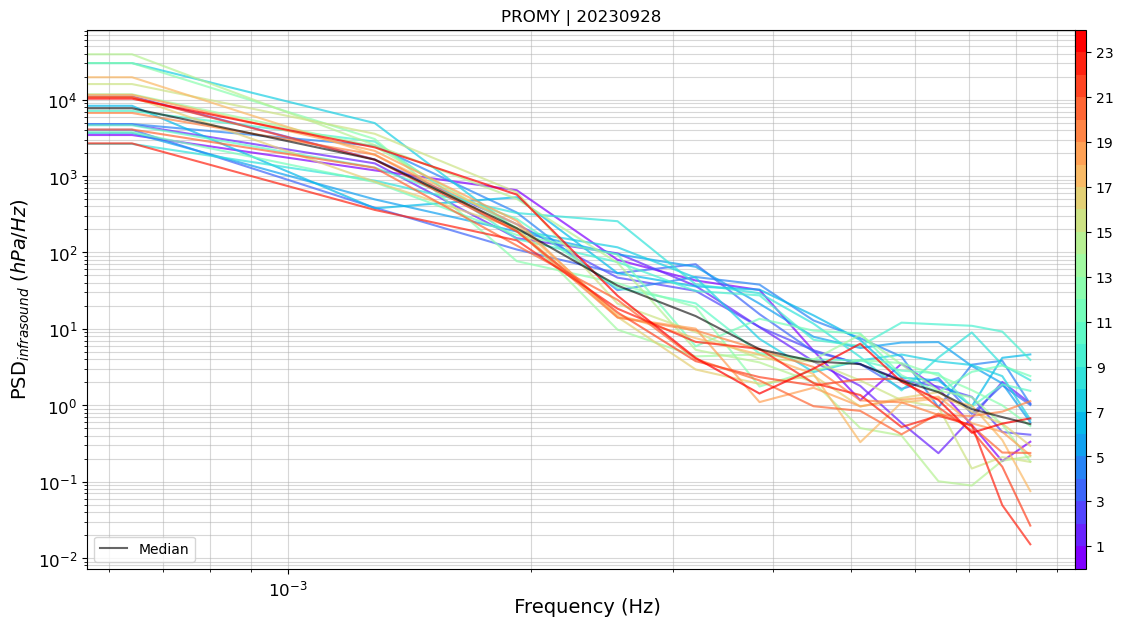


   -> saving /import/kilauea-data/LNM2/figures/PROMY_infrasound_20230928.png ...

   -> Done

2023_PROMY_3600_20230929_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


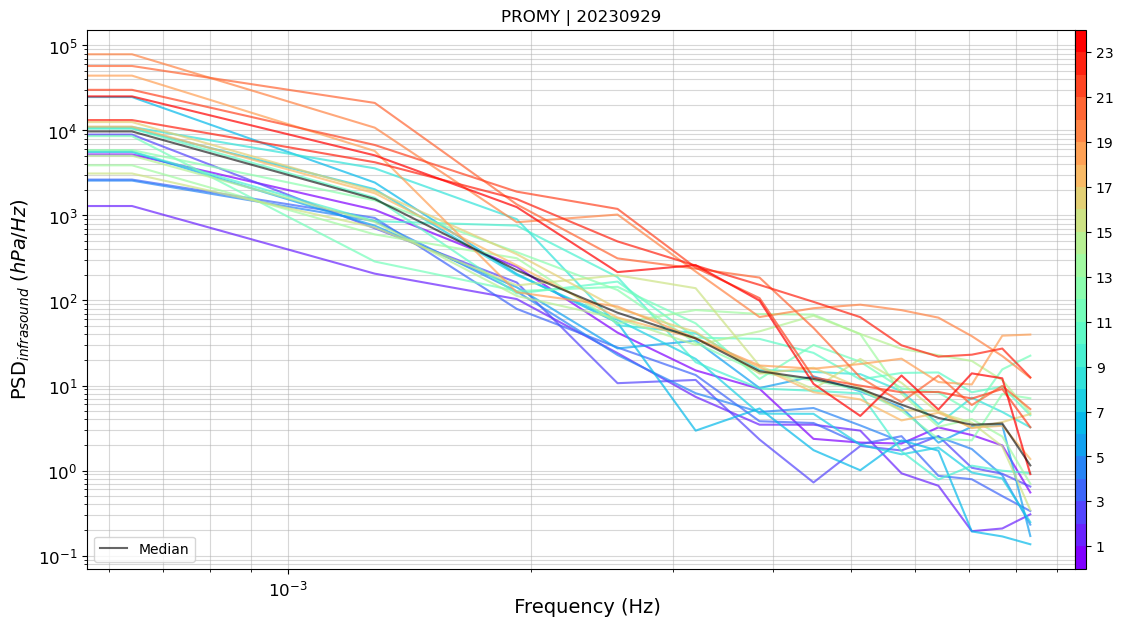


   -> saving /import/kilauea-data/LNM2/figures/PROMY_infrasound_20230929.png ...

   -> Done

2023_PROMY_3600_20230930_hourly.pkl
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


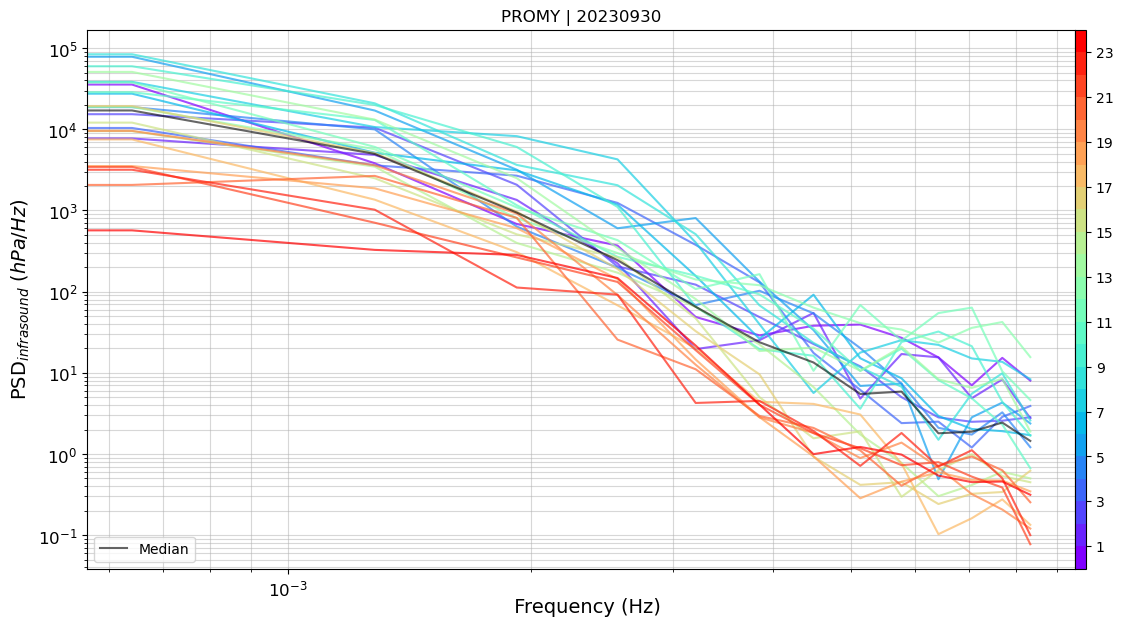


   -> saving /import/kilauea-data/LNM2/figures/PROMY_infrasound_20230930.png ...

   -> Done



In [19]:
config['files'] = [file for file in os.listdir(config['inpath']) if "hourly" in file]
config['files'].sort()


psds_medians_out, times_out = [],[]

for file in config['files']:

    print(file)

    day = file.split("_")[-2]

    # config['outpath_figname'] = config['station']+"_absolute"+"_"+day
    config['outpath_figname'] = config['station']+"_infrasound"+"_"+day

    if os.path.isfile(config['outpath_figures']+config['outpath_figname']):
        continue

    ff_Z = pickle.load(open(f"{config['inpath'].replace('Z','Z')}{config['inname'].replace('Z','Z')}_frequency_axis.pkl", 'rb'))
#     ff_N = pickle.load(open(f"{config['inpath'].replace('Z','N')}{config['inname'].replace('Z','N')}_frequency_axis.pkl", 'rb'))
#     ff_E = pickle.load(open(f"{config['inpath'].replace('Z','E')}{config['inname'].replace('Z','E')}_frequency_axis.pkl", 'rb'))

    ADR_Z = __load_data_file(config['inpath'].replace("Z","Z"), file.replace("Z","Z"))
#     ADR_N = __load_data_file(config['inpath'].replace("Z","N"), file.replace("Z","N"))
#     ADR_E = __load_data_file(config['inpath'].replace("Z","E"), file.replace("Z","E"))

#     ADR_Z, ff_Z = __cut_frequencies_array(ADR_Z, ff_Z, config['frequency_limits'][0], config['frequency_limits'][1])
#     ADR_N, ff_N = __cut_frequencies_array(ADR_N, ff_N, config['frequency_limits'][0], config['frequency_limits'][1])
#     ADR_E, ff_E = __cut_frequencies_array(ADR_E, ff_E, config['frequency_limits'][0], config['frequency_limits'][1])

    ADR_Z, rejected_Z = __remove_noisy_psds(ADR_Z, threshold_mean=config['thres'])
#     ADR_N, rejected_N = __remove_noisy_psds(ADR_N, threshold_mean=config['thres'])
#     ADR_E, rejected_E = __remove_noisy_psds(ADR_E, threshold_mean=config['thres'])

    fig = __makeplot_colorlines(config, ff_Z,  ADR_Z, rejected_Z, day)

#     fig = __makeplot_colorlines_overview(config,
#                                          [ff_Z, ff_N, ff_E],
#                                          [ADR_Z, ADR_N, ADR_E],
#                                          [rejected_Z, rejected_N, rejected_E],
#                                          day)


#     fig.savefig(config['outpath_figures']+config['outpath_figname'], format="png", transparent=False)
    __savefig(fig, outpath=config['outpath_figures'], outname=config['outpath_figname'], mode="png", dpi=300)

In [28]:
    ## output data
#     psds_medians_out.append(psds_median)
#     times_out.append(time)

# ## write output
# output = {"times": array(times_out).astype(int), "frequencies": array(ff), "psds_medians": array(psds_medians_out)}

# with open(f"{config['inpath']}{config['inname']}_psds_filtered_medians.pkl", 'wb') as file:
#     pickle.dump(output, file, protocol=pickle.HIGHEST_PROTOCOL)